In [1]:
import os
os.chdir('../')

In [2]:
import scanpy as sc
# load meta-set
metaset_path = '/projects/b1042/GoyalLab/lschwartz/dl/data/subset_raw_C:all_N:100_P:20.h5ad'
adata = sc.read(metaset_path)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [3]:
# assign number of cpus to use as data loaders
n_cpus = 10

In [4]:
# Maybe instead of duplicating cells, generate synthetic ones
# from imblearn.over_sampling import SMOTE

In [5]:
n_perts_per_cell_type = adata.obs[adata.obs.perturbation!='control'].perturbation.nunique()

In [6]:
# draw equal amount of cells per exact class
n_samples = 1000
n_control = n_samples * n_perts_per_cell_type
target_cells = adata.obs.groupby(['exact_perturbation']).apply(
    lambda x: x.sample(n=n_control, replace=True) if x.name.startswith('control') else x.sample(n=n_samples, replace=True)
).index.get_level_values(1).tolist()
subset = adata[target_cells].copy()

/tmp/ipykernel_64427/14699618.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_cells = adata.obs.groupby(['exact_perturbation']).apply(
/tmp/ipykernel_64427/14699618.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_cells = adata.obs.groupby(['exact_perturbation']).apply(
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("

In [7]:
subset

AnnData object with n_obs × n_vars = 76000 × 15639
    obs: 'perturbation', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'dataset', 'perturbation_type', 'exact_perturbation'
    var: 'mean', 'std'
    uns: 'log1p'

In [12]:
%load_ext autoreload
%autoreload 2

In [19]:
### try a disentagled classifier on this
from src.data import MultiLabelAnnDataModule
import torch
import pytorch_lightning as pl

loading_params = {
    'batch_size': 256,
    'train_val_split': 0.6,
}

# Initialize data module
data_module = MultiLabelAnnDataModule(
    adata=subset,
    cell_type_col='celltype',
    pert_type_col='perturbation_type',
    pert_col='perturbation',
    train_val_split=loading_params.get('train_val_split'),
    batch_size=loading_params.get('batch_size'),
    num_workers=n_cpus
)

from src.multivae import MultiPropertyVAE
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

scheduler = ReduceLROnPlateau

# Set hyperparameters
hp = {
    'encoder_latent_dim': 256,
    'shared_latent_dim': 128,
    'cell_type_latent_dim': 32,
    'pert_type_latent_dim': 16,
    'pert_latent_dim': 256,
    'hidden_dims': [1024, 512],
    'classifier_hidden_dims': [512, 256, 128],
    'learning_rate': 1e-3,
    'alpha': 1,
    'beta': 0.1,
    'cell_type_weight': 0.1,
    'perturbation_type_weight': 0,
    'dropout_rate': 0.05,
    'scheduler': scheduler,
    'monitor_loss': 'val_pert_loss'
}
# set hidden dimensions
if 'hidden_dims' not in hp:
    # set to two layers
    hp['hidden_dims'] = [hp.get('latent_dim')*4, hp.get('latent_dim')*2]

# Initialize model
multi_model = MultiPropertyVAE(
    input_dim=subset.n_vars,
    cell_type_classes=data_module.cell_type_classes,
    pert_type_classes=data_module.pert_type_classes,
    pert_classes=data_module.pert_classes,
    **hp
)

# set precision for training
torch.set_float32_matmul_precision('high')

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    enable_progress_bar=True,
    logger=pl.loggers.TensorBoardLogger('logs/raw/'),
    callbacks=[
        pl.callbacks.ModelCheckpoint(monitor='val_pert_acc'),
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ],
    #gradient_clip_val=1.0,
    #accumulate_grad_batches=1
)

Dataset initialized with 76000 cells
cell_type classes: 2
cell_type labels: {'lymphoblasts': 0, 'retinal pigment epithelial cells': 1}
pert_type classes: 1
pert_type labels: {'CRISPRi': 0}
pert classes: 20
pert labels: {'ANAPC15': 0, 'BCAR1': 1, 'CACNB3': 2, 'CADM4': 3, 'ESPN': 4, 'GAB2': 5, 'GFM1': 6, 'GTF3C4': 7, 'MRPL35': 8, 'MRPL36': 9, 'NBPF12': 10, 'PPP2R1A': 11, 'PPP6C': 12, 'PRODH': 13, 'PSMG3': 14, 'SLC1A5': 15, 'SRSF11': 16, 'TARDBP': 17, 'ZNF718': 18, 'control': 19}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
%reload_ext tensorboard
%tensorboard --logdir logs/raw

In [21]:
# Train the model
trainer.fit(multi_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                 | Type                      | Params | Mode 
----------------------------------------------------------------------------
0  | encoder              | Encoder                   | 16.8 M | train
1  | fc_cell_mu           | Linear                    | 8.2 K  | train
2  | fc_cell_var          | Linear                    | 8.2 K  | train
3  | fc_pert_type_mu      | Linear                    | 4.1 K  | train
4  | fc_pert_type_var     | Linear                    | 4.1 K  | train
5  | fc_pert_mu           | Linear                    | 65.8 K | train
6  | fc_pert_var          | Linear                    | 65.8 K | train
7  | fc_shared_mu         | Linear                    | 32.9 K | train
8  | fc_shared_var        | Linear                    | 32.9 K | train
9  | decoder              | Decoder                   | 16.8 M | train
10 | cell_type_classifier | Classifier                | 183 K  | train
11 | pert_type_classifier | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 30400 cells
cell_type classes: 2
cell_type labels: {'lymphoblasts': 0, 'retinal pigment epithelial cells': 1}
pert_type classes: 1
pert_type labels: {'CRISPRi': 0}
pert classes: 20
pert labels: {'ANAPC15': 0, 'BCAR1': 1, 'CACNB3': 2, 'CADM4': 3, 'ESPN': 4, 'GAB2': 5, 'GFM1': 6, 'GTF3C4': 7, 'MRPL35': 8, 'MRPL36': 9, 'NBPF12': 10, 'PPP2R1A': 11, 'PPP6C': 12, 'PRODH': 13, 'PSMG3': 14, 'SLC1A5': 15, 'SRSF11': 16, 'TARDBP': 17, 'ZNF718': 18, 'control': 19}
Dataset initialized with 45600 cells                                       
cell_type classes: 2
cell_type labels: {'lymphoblasts': 0, 'retinal pigment epithelial cells': 1}
pert_type classes: 1
pert_type labels: {'CRISPRi': 0}
pert classes: 20
pert labels: {'ANAPC15': 0, 'BCAR1': 1, 'CACNB3': 2, 'CADM4': 3, 'ESPN': 4, 'GAB2': 5, 'GFM1': 6, 'GTF3C4': 7, 'MRPL35': 8, 'MRPL36': 9, 'NBPF12': 10, 'PPP2R1A': 11, 'PPP6C': 12, 'PRODH': 13, 'PSMG3': 14, 'SLC1A5': 15, 'SRS

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 21: 100%|██████████| 179/179 [00:12<00:00, 14.82it/s, v_num=19, train_precision=0.571, train_recall=0.583, train_f1=0.957, train_loss=0.716, train_recon_loss=0.668, train_kl_loss=0.132, train_kl_loss_pert=0.0882, train_cell_type_loss=0.000369, train_pert_type_loss=0.910, train_pert_loss=0.0349, train_cell_type_acc=1.000, train_pert_acc=0.875, train_class_loss=0.035, val_precision=0.657, val_recall=0.625, val_f1=0.790, val_loss=0.768, val_recon_loss=0.613, val_kl_loss=0.115, val_kl_loss_pert=0.0738, val_cell_type_loss=0.00109, val_pert_type_loss=0.848, val_pert_loss=0.144, val_cell_type_acc=1.000, val_pert_acc=0.694, val_class_loss=0.144]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 179/179 [00:11<00:00, 15.21it/s, v_num=19, train_precision=0.450, train_recall=0.400, train_f1=1.000, train_loss=0.697, train_recon_loss=0.662, train_kl_loss=0.110, train_kl_loss_pert=0.0701, train_cell_type_loss=0.000143, train_pert_type_loss=0.882, train_pert_loss=0.02

### Check latent space representation of trained model

In [18]:
use_checkpoint = False

if use_checkpoint:
    from src.multivae import MultiPropertyVAE
    # load model from checkpoint
    checkpoint_p = 'logs/raw/lightning_logs/baba/checkpoints/epoch=3-step=228.ckpt'
    multi_model = MultiPropertyVAE.load_from_checkpoint(checkpoint_p)

In [53]:
# plot latent space representation
# 1. Basic extraction of latent representations
latents, labels = multi_model.get_latent_representation(
    data_module.train_dataloader(),
    return_labels=True
)

print(f"Latent space shape: {latents.shape}")

Dataset initialized with 45600 cells
cell_type classes: 2
cell_type labels: {'lymphoblasts': 0, 'retinal pigment epithelial cells': 1}
pert_type classes: 1
pert_type labels: {'CRISPRi': 0}
pert classes: 20
pert labels: {'ANAPC15': 0, 'BCAR1': 1, 'CACNB3': 2, 'CADM4': 3, 'ESPN': 4, 'GAB2': 5, 'GFM1': 6, 'GTF3C4': 7, 'MRPL35': 8, 'MRPL36': 9, 'NBPF12': 10, 'PPP2R1A': 11, 'PPP6C': 12, 'PRODH': 13, 'PSMG3': 14, 'SLC1A5': 15, 'SRSF11': 16, 'TARDBP': 17, 'ZNF718': 18, 'control': 19}
Latent space shape: (45600, 256)


In [54]:
# convert one-hot back to indices and those back to labels
import pandas as pd
import numpy as np
labels_df = pd.DataFrame({k: torch.argmax(torch.Tensor(np.concatenate(l)), dim=1) for k, l in labels.items()})

In [55]:
decoders = data_module.val_dataloader().dataset.label_decoders

Dataset initialized with 30400 cells
cell_type classes: 2
cell_type labels: {'lymphoblasts': 0, 'retinal pigment epithelial cells': 1}
pert_type classes: 1
pert_type labels: {'CRISPRi': 0}
pert classes: 20
pert labels: {'ANAPC15': 0, 'BCAR1': 1, 'CACNB3': 2, 'CADM4': 3, 'ESPN': 4, 'GAB2': 5, 'GFM1': 6, 'GTF3C4': 7, 'MRPL35': 8, 'MRPL36': 9, 'NBPF12': 10, 'PPP2R1A': 11, 'PPP6C': 12, 'PRODH': 13, 'PSMG3': 14, 'SLC1A5': 15, 'SRSF11': 16, 'TARDBP': 17, 'ZNF718': 18, 'control': 19}


In [56]:
labels_df.cell_type = [decoders.get('cell_type').get(x) for x in labels_df.cell_type]
labels_df.perturbation_type = [decoders.get('pert_type').get(x) for x in labels_df.perturbation_type]
labels_df.perturbation = [decoders.get('pert').get(x) for x in labels_df.perturbation]

In [57]:
import anndata as ad
# Create AnnData object
adata_latent = ad.AnnData(latents)
adata_latent.obs = labels_df
# Compute UMAP
sc.pp.neighbors(adata_latent, use_rep='X')
sc.tl.umap(adata_latent)

Epoch 73: 100%|██████████| 45/45 [31:00<00:00,  0.02it/s, v_num=18, train_precision=0.211, train_recall=0.232, train_f1=0.990, train_loss=0.755, train_recon_loss=0.627, train_kl_loss=0.0465, train_kl_loss_pert=0.0176, train_cell_type_loss=0.0374, train_pert_type_loss=0.587, train_pert_loss=0.0778, train_cell_type_acc=0.985, train_pert_acc=0.627, train_class_loss=0.0815, val_precision=0.183, val_recall=0.177, val_f1=0.790, val_loss=0.836, val_recon_loss=0.627, val_kl_loss=0.0471, val_kl_loss_pert=0.0177, val_cell_type_loss=0.0272, val_pert_type_loss=0.595, val_pert_loss=0.160, val_cell_type_acc=0.990, val_pert_acc=0.467, val_class_loss=0.163]

                                             

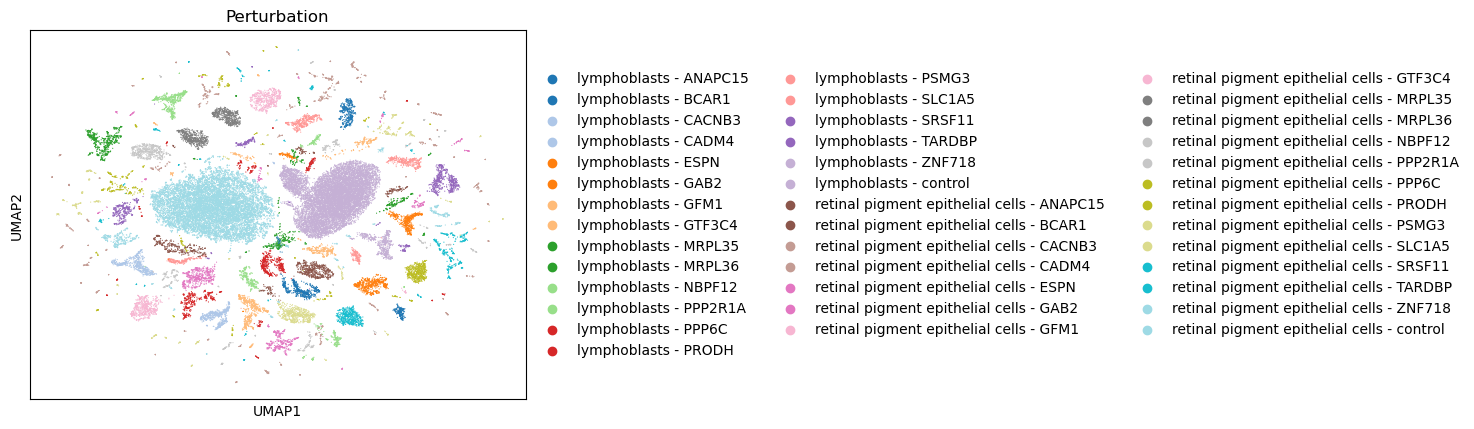

In [58]:
import seaborn as sns
adata_latent.obs['label'] = adata_latent.obs.cell_type.str.cat(adata_latent.obs.perturbation, sep=' - ')
sc.pl.umap(adata_latent, color='label', title='Perturbation', palette='tab20')

In [61]:
# add dataset information
dataloader = data_module.train_dataloader()
#dataloader.dataset.adata.obs.dataset

Dataset initialized with 45600 cells
cell_type classes: 2
cell_type labels: {'lymphoblasts': 0, 'retinal pigment epithelial cells': 1}
pert_type classes: 1
pert_type labels: {'CRISPRi': 0}
pert classes: 20
pert labels: {'ANAPC15': 0, 'BCAR1': 1, 'CACNB3': 2, 'CADM4': 3, 'ESPN': 4, 'GAB2': 5, 'GFM1': 6, 'GTF3C4': 7, 'MRPL35': 8, 'MRPL36': 9, 'NBPF12': 10, 'PPP2R1A': 11, 'PPP6C': 12, 'PRODH': 13, 'PSMG3': 14, 'SLC1A5': 15, 'SRSF11': 16, 'TARDBP': 17, 'ZNF718': 18, 'control': 19}


In [62]:
adata_latent.obs['dataset'] = dataloader.dataset.adata.obs.iloc[data_module.train_indices].dataset.tolist()

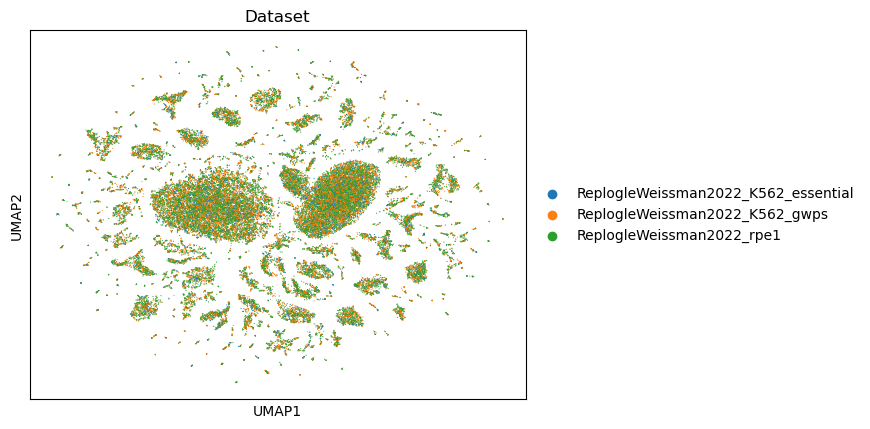

In [63]:
sc.pl.umap(adata_latent, color='dataset', title='Dataset')

In [64]:
cell_cm = sns.color_palette('tab10')

In [65]:
cell_cm = {'retinal pigment epithelial cells': cell_cm[-1],
               'lymphoblasts': cell_cm[4]}

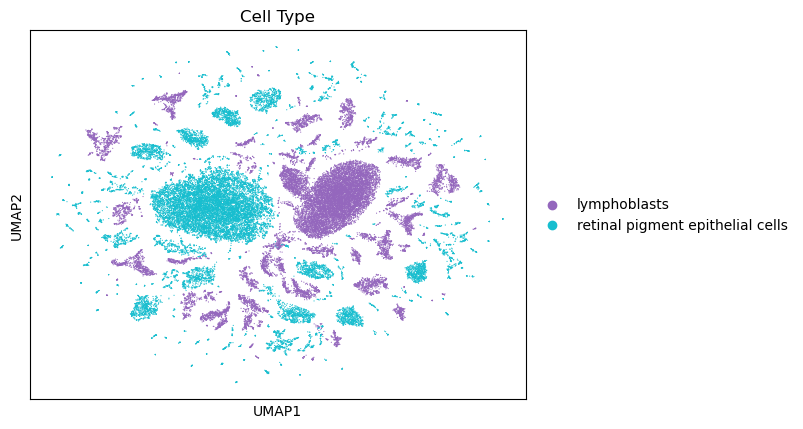

In [66]:
sc.pl.umap(adata_latent, color='cell_type', palette=cell_cm, title='Cell Type')

In [59]:
mask = adata_latent.obs.perturbation != 'control'
adata_latent.obs['controls'] = adata_latent.obs.cell_type.str.cat(adata_latent.obs.perturbation_type, sep=';')
adata_latent.obs.loc[mask,'controls'] = adata_latent.obs.perturbation

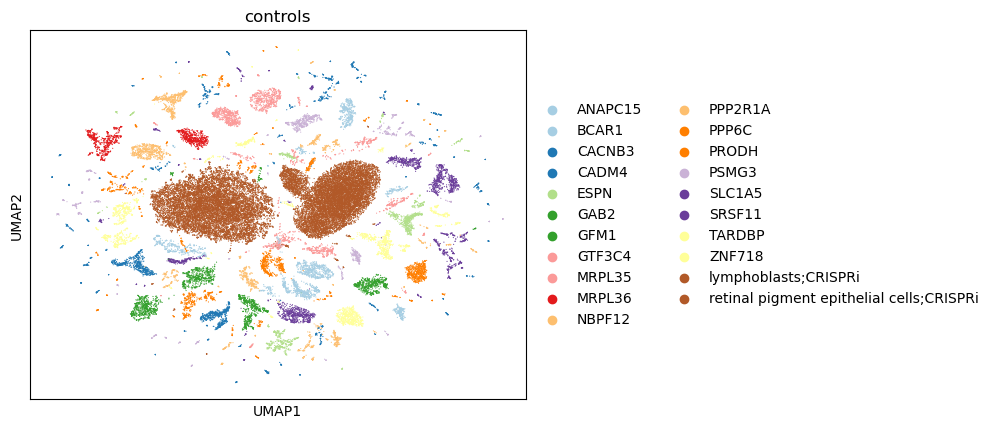

In [60]:
sc.pl.umap(adata_latent, color='controls', palette='Paired')

### VAE with concatenated perturbation class

In [76]:
import pytorch_lightning as pl
import torch
from src.vae import VAE
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

from src.vae import AnnDataModule


loading_params = {
    'batch_size': 128,
    'train_val_split': 0.8,
    'target_col': 'exact_perturbation'
}

# Initialize data module
data_module = AnnDataModule(
    adata=subset,
    label_col=loading_params.get('target_col'),
    train_val_split=loading_params.get('train_val_split'),
    batch_size=loading_params.get('batch_size'),
    num_workers=n_cpus
)

scheduler = ReduceLROnPlateau

# Set hyperparameters
hp = {
    'latent_dim': 128,
    'hidden_dims': [512, 256, 128],
    'classifier_hidden_dims': [64],
    'learning_rate': 1e-3,
    'alpha': 1,
    'dynamic_alpha': False,
    'beta': 1,
    'dropout_rate': 0,
    'scheduler': scheduler,
    'monitor_loss': 'train_class_loss'
}
# set hidden dimensions
if 'hidden_dims' not in hp:
    # set to two layers
    hp['hidden_dims'] = [hp.get('latent_dim')*4, hp.get('latent_dim')*2]

# Initialize model
combined_model = VAE(
    input_dim=adata.n_vars,
    num_classes=data_module.num_classes,
    **hp
)

# set precision for training
torch.set_float32_matmul_precision('medium')

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    enable_progress_bar=True,
    logger=pl.loggers.TensorBoardLogger('logs/concat_vae/'),
    callbacks=[
        pl.callbacks.ModelCheckpoint(monitor='val_loss'),
        pl.callbacks.EarlyStopping(monitor='val_class_loss', patience=10)
    ],
    #gradient_clip_val=1.0,
    #accumulate_grad_batches=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [174]:
%reload_ext tensorboard
%tensorboard --logdir logs/concat_vae --port 6007

In [78]:
trainer.fit(combined_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 9.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | train_confmat   | MulticlassConfusionMatrix | 0      | train
8 | val_confmat     | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.688    Total estimated model params size (MB)
44        Modules in train mode
0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 4000 cells
Labels encoded: {'ANAPC15;lymphoblasts;CRISPRi': 0, 'GFM1;retinal pigment epithelial cells;CRISPRi': 1, 'KIF11;lymphoblasts;CRISPRi': 2, 'KLF1;lymphoblasts;CRISPRa': 3, 'MRPL35;retinal pigment epithelial cells;CRISPRi': 4, 'MRPL36;retinal pigment epithelial cells;CRISPRi': 5, 'NUP205;lymphoblasts;CRISPRi': 6, 'PINK1;lymphoblasts;CRISPRi': 7, 'PPP2R1A;lymphoblasts;CRISPRi': 8, 'PPP6C;retinal pigment epithelial cells;CRISPRi': 9, 'RPL3;lymphoblasts;CRISPRi': 10, 'SLC1A5;retinal pigment epithelial cells;CRISPRi': 11, 'SLC39A9;lymphoblasts;CRISPRi': 12, 'TARDBP;retinal pigment epithelial cells;CRISPRi': 13, 'TFAM;retinal pigment epithelial cells;CRISPRi': 14, 'control;T cells;CRISPR-cas9, TCR stim': 15, 'control;lymphoblasts;CRISPRa': 16, 'control;lymphoblasts;CRISPRi': 17, 'control;melanocytes;CRISPR-cas9': 18, 'control;retinal pigment epithelial cells;CRISPRi': 19}
Number of classes: 20
Dataset initiali

In [79]:
# plot latent space representation
# 1. Basic extraction of latent representations
latents, labels = combined_model.get_latent_representation(
    data_module.train_dataloader(),
    return_labels=True
)

print(f"Latent space shape: {latents.shape}")

Dataset initialized with 16000 cells
Labels encoded: {'ANAPC15;lymphoblasts;CRISPRi': 0, 'GFM1;retinal pigment epithelial cells;CRISPRi': 1, 'KIF11;lymphoblasts;CRISPRi': 2, 'KLF1;lymphoblasts;CRISPRa': 3, 'MRPL35;retinal pigment epithelial cells;CRISPRi': 4, 'MRPL36;retinal pigment epithelial cells;CRISPRi': 5, 'NUP205;lymphoblasts;CRISPRi': 6, 'PINK1;lymphoblasts;CRISPRi': 7, 'PPP2R1A;lymphoblasts;CRISPRi': 8, 'PPP6C;retinal pigment epithelial cells;CRISPRi': 9, 'RPL3;lymphoblasts;CRISPRi': 10, 'SLC1A5;retinal pigment epithelial cells;CRISPRi': 11, 'SLC39A9;lymphoblasts;CRISPRi': 12, 'TARDBP;retinal pigment epithelial cells;CRISPRi': 13, 'TFAM;retinal pigment epithelial cells;CRISPRi': 14, 'control;T cells;CRISPR-cas9, TCR stim': 15, 'control;lymphoblasts;CRISPRa': 16, 'control;lymphoblasts;CRISPRi': 17, 'control;melanocytes;CRISPR-cas9': 18, 'control;retinal pigment epithelial cells;CRISPRi': 19}
Number of classes: 20
Latent space shape: (16000, 128)


In [80]:
decoder = data_module.train_dataloader().dataset.label_decoder

Dataset initialized with 16000 cells
Labels encoded: {'ANAPC15;lymphoblasts;CRISPRi': 0, 'GFM1;retinal pigment epithelial cells;CRISPRi': 1, 'KIF11;lymphoblasts;CRISPRi': 2, 'KLF1;lymphoblasts;CRISPRa': 3, 'MRPL35;retinal pigment epithelial cells;CRISPRi': 4, 'MRPL36;retinal pigment epithelial cells;CRISPRi': 5, 'NUP205;lymphoblasts;CRISPRi': 6, 'PINK1;lymphoblasts;CRISPRi': 7, 'PPP2R1A;lymphoblasts;CRISPRi': 8, 'PPP6C;retinal pigment epithelial cells;CRISPRi': 9, 'RPL3;lymphoblasts;CRISPRi': 10, 'SLC1A5;retinal pigment epithelial cells;CRISPRi': 11, 'SLC39A9;lymphoblasts;CRISPRi': 12, 'TARDBP;retinal pigment epithelial cells;CRISPRi': 13, 'TFAM;retinal pigment epithelial cells;CRISPRi': 14, 'control;T cells;CRISPR-cas9, TCR stim': 15, 'control;lymphoblasts;CRISPRa': 16, 'control;lymphoblasts;CRISPRi': 17, 'control;melanocytes;CRISPR-cas9': 18, 'control;retinal pigment epithelial cells;CRISPRi': 19}
Number of classes: 20


In [81]:
# convert one-hot to label indices
labels = torch.argmax(torch.Tensor(labels), dim=1)

In [82]:
# Convert numeric labels back to original names
label_names = [decoder.get(int(label)) for label in labels]

In [97]:
import anndata as ad
# Create AnnData object
adata_latent = ad.AnnData(latents)
adata_latent.obs[data_module.label_col] = label_names

In [99]:
adata_latent.obs[['perturbation', 'cell_type', 'method']] = adata_latent.obs['exact_perturbation'].str.split(';', expand=True)

In [102]:
mask = adata_latent.obs.perturbation != 'control'
adata_latent.obs['controls'] = adata_latent.obs.iloc[:,0].tolist()
adata_latent.obs.loc[mask,'controls'] = 'perturbed'

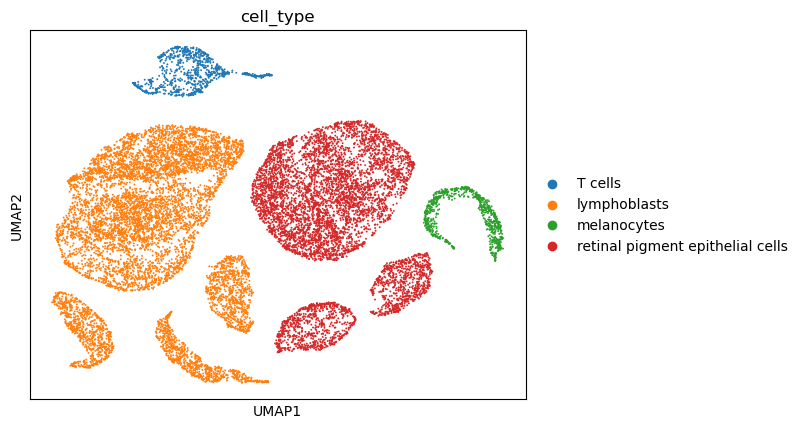

In [107]:
# Compute UMAP
sc.pp.neighbors(adata_latent, use_rep='X')
sc.tl.umap(adata_latent)
# Create plot
sc.pl.umap(adata_latent, color='cell_type')

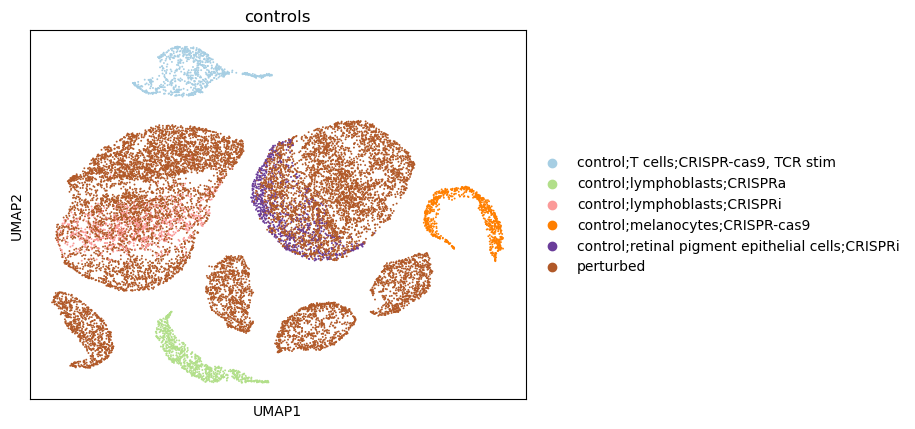

In [108]:
sc.pl.umap(adata_latent, color=['controls'], palette='Paired')

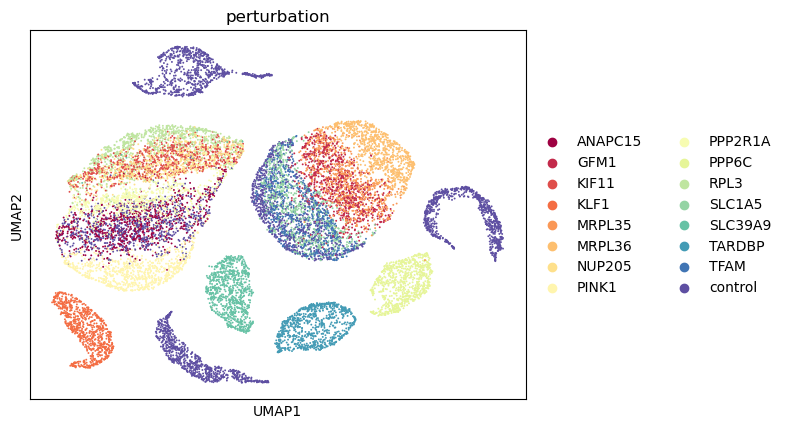

In [110]:
sc.pl.umap(adata_latent, color=['perturbation'], palette='Spectral')

### Plot actual umap and compare to latent space representation

In [404]:
# compare to actual UMAP
print('calculating pca')
sc.pp.pca(subset)
print('calculating neighbors')
sc.pp.neighbors(subset)
print('calculating umap')
sc.tl.umap(subset)

calculating pca
calculating neighbors
calculating umap


plotting umap


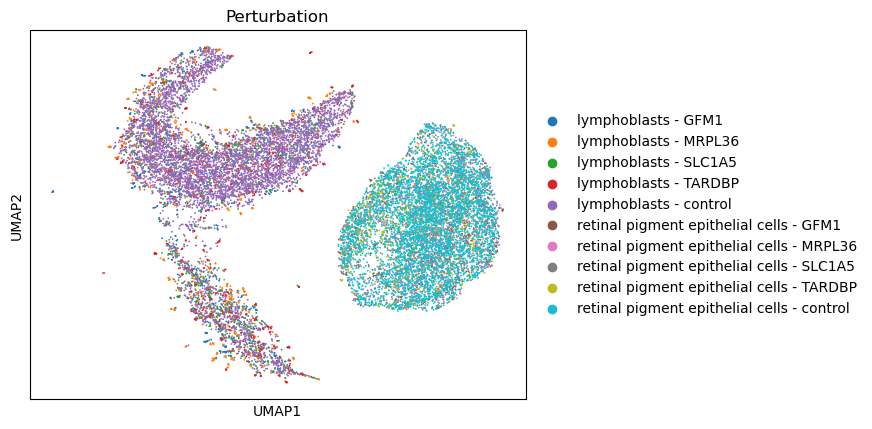

In [405]:
print('plotting umap')
subset.obs['label'] = subset.obs.celltype.str.cat(subset.obs.perturbation, sep=' - ')
sc.pl.umap(subset, color='label', title='Perturbation', palette='tab10')

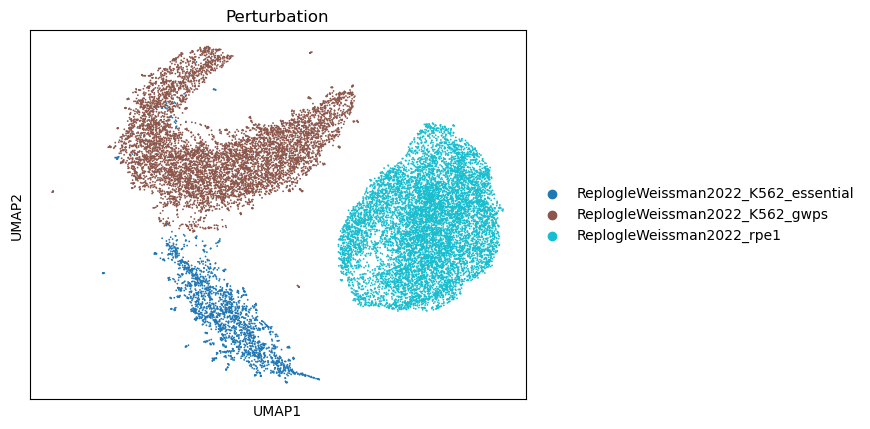

In [406]:
sc.pl.umap(subset, color='dataset', title='Perturbation', palette='tab10')

In [50]:
%reload_ext tensorboard
%tensorboard --logdir hyperparameter_search/

Reusing TensorBoard on port 6006 (pid 39786), started 2:07:59 ago. (Use '!kill 39786' to kill it.)

In [ ]:
### Hyperparameter search
from src.vae import HyperparameterSearch

# Define base model parameters (fixed parameters)
base_model_params = {
    'input_dim': adata.n_vars,
    'num_classes': data_module.num_classes
}

# Define search space
search_space = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'beta': [0.1, 0.5],         # KL weight
    'alpha': [1.0, 2.0],        # Classification weight
    'dropout_rate': [0, 0.1],       # Dropout rate
    'latent_dim': [64, 128],                  # Number of latent dimensions
    'hidden_dims': [[512, 256], [1024, 512]]     # Different number of hidden dimensions
}

# Initialize and run search
search = HyperparameterSearch(
    data_module=data_module,
    base_model_params=base_model_params,
    search_space=search_space,
    max_epochs=15,
    patience=10,
    search_dir='hyperparameter_search',
    gpu=True
)

# Run the search
results_df = search.run_search()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Starting hyperparameter search with 96 combinations

Trial 1/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [512, 256]}


2024-11-19 20:52:55.033584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 20:52:55.047719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 20:52:55.065408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 20:52:55.070970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:52:55.084848: I tensorflow/core/platform/cpu_feature_guar

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.07it/s, v_num=0, train_loss=1.080, train_recon_loss=0.398, train_kl_loss=0.391, train_class_loss=0.648, train_accuracy=0.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.75it/s, v_num=0, train_loss=0.899, train_recon_loss=0.277, train_kl_loss=0.456, train_class_loss=0.576, train_accuracy=0.297, val_loss=1.070, val_recon_loss=0.382, val_kl_loss=0.378, val_class_loss=0.648, val_accuracy=0.306]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:07<00:00, 12.79it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:10<00:00,  8.61it/s, v_num=0, train_loss=0.599, train_recon_loss=0.116, train_kl_loss=0.595, train_class_loss=0.424, train_accuracy=0.341, val_loss=0.597, val_recon_loss=0.111, val_kl_loss=0.587, val_class_loss=0.427, val_accuracy=0.311]

Trial 2/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.77it/s, v_num=0, train_loss=0.947, train_recon_loss=0.283, train_kl_loss=0.500, train_class_loss=0.614, train_accuracy=0.292]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.68it/s, v_num=0, train_loss=0.778, train_recon_loss=0.165, train_kl_loss=0.586, train_class_loss=0.555, train_accuracy=0.299, val_loss=0.938, val_recon_loss=0.277, val_kl_loss=0.479, val_class_loss=0.613, val_accuracy=0.319]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:07<00:00, 11.88it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:14<00:00,  6.64it/s, v_num=0, train_loss=0.549, train_recon_loss=0.064, train_kl_loss=0.638, train_class_loss=0.421, train_accuracy=0.305, val_loss=0.545, val_recon_loss=0.0631, val_kl_loss=0.631, val_class_loss=0.419, val_accuracy=0.323]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra


Trial 3/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 128, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.40it/s, v_num=0, train_loss=1.000, train_recon_loss=0.367, train_kl_loss=0.319, train_class_loss=0.601, train_accuracy=0.315]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.69it/s, v_num=0, train_loss=0.829, train_recon_loss=0.257, train_kl_loss=0.361, train_class_loss=0.535, train_accuracy=0.333, val_loss=1.010, val_recon_loss=0.375, val_kl_loss=0.316, val_class_loss=0.601

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:10<00:00,  8.67it/s, v_num=0, train_loss=0.566, train_recon_loss=0.110, train_kl_loss=0.454, train_class_loss=0.411, train_accuracy=0.341, val_loss=0.568, val_recon_loss=0.110, val_kl_loss=0.451, val_class_loss=0.413, val_accuracy=0.317]

Trial 4/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 128, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.7 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.78it/s, v_num=0, train_loss=0.886, train_recon_loss=0.292, train_kl_loss=0.384, train_class_loss=0.556, train_accuracy=0.299]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.44it/s, v_num=0, train_loss=0.723, train_recon_loss=0.176, train_kl_loss=0.443, train_class_loss=0.503, train_accuracy=0.292, val_loss=0.882, val_recon_loss=0.285, val_kl_loss=0.367, val_class_loss=0.560, val_accuracy=0.316]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.74it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:15<00:00,  5.95it/s, v_num=0, train_loss=0.517, train_recon_loss=0.0666, train_kl_loss=0.495, train_class_loss=0.401, train_accuracy=0.320, val_loss=0.513, val_recon_loss=0.060, val_kl_loss=0.494, val_class_loss=0.404, val_accuracy=0.318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra


Trial 5/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 64, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.57it/s, v_num=0, train_loss=1.090, train_recon_loss=0.444, train_kl_loss=0.423, train_class_loss=0.599, train_accuracy=0.331]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.61it/s, v_num=0, train_loss=0.931, train_recon_loss=0.346, train_kl_loss=0.459, train_class_loss=0.539, train_accuracy=0.318, val_loss=1.030, val_recon_loss=0.389, val_kl_loss=0.404, val_class_loss=0.60

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:11<00:00,  8.44it/s, v_num=0, train_loss=0.647, train_recon_loss=0.178, train_kl_loss=0.561, train_class_loss=0.413, train_accuracy=0.341, val_loss=0.610, val_recon_loss=0.136, val_kl_loss=0.538, val_class_loss=0.421, val_accuracy=0.318]

Trial 6/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:08<00:00, 11.44it/s, v_num=0, train_loss=0.968, train_recon_loss=0.358, train_kl_loss=0.486, train_class_loss=0.562, train_accuracy=0.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.55it/s, v_num=0, train_loss=0.797, train_recon_loss=0.233, train_kl_loss=0.575, train_class_loss=0.507, train_accuracy=0.333, val_loss=0.911, val_recon_loss=0.302, val_kl_loss=0.465, val_class_loss=0.562, val_accuracy=0.322]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.45it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.32it/s, v_num=0, train_loss=0.574, train_recon_loss=0.109, train_kl_loss=0.634, train_class_loss=0.402, train_accuracy=0.367, val_loss=0.540, val_recon_loss=0.0707, val_kl_loss=0.614, val_class_loss=0.408, val_accuracy=0.324]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra


Trial 7/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 128, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.42it/s, v_num=0, train_loss=1.090, train_recon_loss=0.441, train_kl_loss=0.335, train_class_loss=0.615, train_accuracy=0.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.24it/s, v_num=0, train_loss=0.923, train_recon_loss=0.341, train_kl_loss=0.351, train_class_loss=0.547, train_accuracy=0.349, val_loss=1.030, val_recon_loss=0.386, val_kl_loss=0.326, val_class_loss=0.6

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s, v_num=0, train_loss=0.627, train_recon_loss=0.172, train_kl_loss=0.434, train_class_loss=0.412, train_accuracy=0.310, val_loss=0.590, val_recon_loss=0.134, val_kl_loss=0.419, val_class_loss=0.414, val_accuracy=0.323]

Trial 8/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 128, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.7 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:08<00:00, 11.54it/s, v_num=0, train_loss=0.894, train_recon_loss=0.323, train_kl_loss=0.399, train_class_loss=0.531, train_accuracy=0.339]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.59it/s, v_num=0, train_loss=0.748, train_recon_loss=0.217, train_kl_loss=0.437, train_class_loss=0.487, train_accuracy=0.302, val_loss=0.871, val_recon_loss=0.293, val_kl_loss=0.391, val_class_loss=0.539, val_accuracy=0.314]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.44it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.46it/s, v_num=0, train_loss=0.547, train_recon_loss=0.101, train_kl_loss=0.495, train_class_loss=0.397, train_accuracy=0.318, val_loss=0.519, val_recon_loss=0.0701, val_kl_loss=0.483, val_class_loss=0.401, val_accuracy=0.328]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tra


Trial 9/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.42it/s, v_num=0, train_loss=1.650, train_recon_loss=0.382, train_kl_loss=0.435, train_class_loss=0.611, train_accuracy=0.302]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.25it/s, v_num=0, train_loss=1.410, train_recon_loss=0.275, train_kl_loss=0.520, train_class_loss=0.543, train_accuracy=0.299, val_loss=1.640, val_recon_loss=0.383, val_kl_loss=0.423, val_class_loss=0.609,

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:11<00:00,  8.45it/s, v_num=0, train_loss=1.010, train_recon_loss=0.111, train_kl_loss=0.663, train_class_loss=0.414, train_accuracy=0.323, val_loss=1.000, val_recon_loss=0.112, val_kl_loss=0.665, val_class_loss=0.412, val_accuracy=0.329]

Trial 10/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.94it/s, v_num=0, train_loss=1.450, train_recon_loss=0.285, train_kl_loss=0.533, train_class_loss=0.555, train_accuracy=0.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 11.81it/s, v_num=0, train_loss=1.240, train_recon_loss=0.174, train_kl_loss=0.621, train_class_loss=0.502, train_accuracy=0.331, val_loss=1.440, val_recon_loss=0.284, val_kl_loss=0.527, val_class_loss=0.554, val_accuracy=0.328]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:07<00:00, 11.84it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.47it/s, v_num=0, train_loss=0.941, train_recon_loss=0.0664, train_kl_loss=0.673, train_class_loss=0.404, train_accuracy=0.331, val_loss=0.938, val_recon_loss=0.0645, val_kl_loss=0.676, val_class_loss=0.403, val_accuracy=0.333]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 11/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0, 'latent_dim': 128, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:08<00:00, 11.39it/s, v_num=0, train_loss=1.600, train_recon_loss=0.380, train_kl_loss=0.353, train_class_loss=0.590, train_accuracy=0.333]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.14it/s, v_num=0, train_loss=1.370, train_recon_loss=0.281, train_kl_loss=0.401, train_class_loss=0.523, train_accuracy=0.362, val_loss=1.610, val_recon_loss=0.386, val_kl_loss=0.349, val_class_loss=0.59

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:11<00:00,  8.39it/s, v_num=0, train_loss=0.970, train_recon_loss=0.118, train_kl_loss=0.513, train_class_loss=0.400, train_accuracy=0.341, val_loss=0.983, val_recon_loss=0.117, val_kl_loss=0.513, val_class_loss=0.408, val_accuracy=0.324]

Trial 12/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0, 'latent_dim': 128, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.7 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:08<00:00, 11.56it/s, v_num=0, train_loss=1.470, train_recon_loss=0.280, train_kl_loss=0.431, train_class_loss=0.575, train_accuracy=0.307]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.61it/s, v_num=0, train_loss=1.250, train_recon_loss=0.172, train_kl_loss=0.520, train_class_loss=0.514, train_accuracy=0.315, val_loss=1.490, val_recon_loss=0.292, val_kl_loss=0.427, val_class_loss=0.576, val_accuracy=0.325]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.42it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.37it/s, v_num=0, train_loss=0.924, train_recon_loss=0.0606, train_kl_loss=0.564, train_class_loss=0.403, train_accuracy=0.344, val_loss=0.920, val_recon_loss=0.0603, val_kl_loss=0.571, val_class_loss=0.401, val_accuracy=0.327]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 13/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0.1, 'latent_dim': 64, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.70it/s, v_num=0, train_loss=1.680, train_recon_loss=0.433, train_kl_loss=0.422, train_class_loss=0.601, train_accuracy=0.299]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.46it/s, v_num=0, train_loss=1.460, train_recon_loss=0.333, train_kl_loss=0.487, train_class_loss=0.541, train_accuracy=0.297, val_loss=1.620, val_recon_loss=0.395, val_kl_loss=0.416, val_class_loss=0.5

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:10<00:00,  8.55it/s, v_num=0, train_loss=1.080, train_recon_loss=0.171, train_kl_loss=0.607, train_class_loss=0.426, train_accuracy=0.315, val_loss=1.010, val_recon_loss=0.135, val_kl_loss=0.593, val_class_loss=0.409, val_accuracy=0.326]

Trial 14/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0.1, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.90it/s, v_num=0, train_loss=1.620, train_recon_loss=0.324, train_kl_loss=0.542, train_class_loss=0.619, train_accuracy=0.302]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=0, train_loss=1.400, train_recon_loss=0.224, train_kl_loss=0.635, train_class_loss=0.555, train_accuracy=0.292, val_loss=1.570, val_recon_loss=0.292, val_kl_loss=0.522, val_class_loss=0.614, val_accuracy=0.323]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.37it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.41it/s, v_num=0, train_loss=1.010, train_recon_loss=0.102, train_kl_loss=0.690, train_class_loss=0.419, train_accuracy=0.320, val_loss=0.968, val_recon_loss=0.0712, val_kl_loss=0.677, val_class_loss=0.415, val_accuracy=0.331]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 15/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0.1, 'latent_dim': 128, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.53it/s, v_num=0, train_loss=1.670, train_recon_loss=0.439, train_kl_loss=0.368, train_class_loss=0.598, train_accuracy=0.292]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.63it/s, v_num=0, train_loss=1.460, train_recon_loss=0.355, train_kl_loss=0.384, train_class_loss=0.534, train_accuracy=0.331, val_loss=1.620, val_recon_loss=0.392, val_kl_loss=0.338, val_class_loss=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s, v_num=0, train_loss=1.060, train_recon_loss=0.178, train_kl_loss=0.483, train_class_loss=0.419, train_accuracy=0.279, val_loss=1.010, val_recon_loss=0.136, val_kl_loss=0.461, val_class_loss=0.414, val_accuracy=0.322]

Trial 16/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.1, 'alpha': 2.0, 'dropout_rate': 0.1, 'latent_dim': 128, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.7 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.94it/s, v_num=0, train_loss=1.480, train_recon_loss=0.334, train_kl_loss=0.427, train_class_loss=0.551, train_accuracy=0.312]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.39it/s, v_num=0, train_loss=1.280, train_recon_loss=0.217, train_kl_loss=0.486, train_class_loss=0.505, train_accuracy=0.302, val_loss=1.420, val_recon_loss=0.298, val_kl_loss=0.400, val_class_loss=0.543, val_accuracy=0.319]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.62it/s, v_num=0, train_lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.32it/s, v_num=0, train_loss=0.977, train_recon_loss=0.0984, train_kl_loss=0.540, train_class_loss=0.412, train_accuracy=0.318, val_loss=0.927, val_recon_loss=0.0751, val_kl_loss=0.520, val_class_loss=0.400, val_accuracy=0.324]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 17/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.82it/s, v_num=0, train_loss=1.180, train_recon_loss=0.478, train_kl_loss=0.148, train_class_loss=0.627, train_accuracy=0.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.41it/s, v_num=0, train_loss=1.040, train_recon_loss=0.400, train_kl_loss=0.154, train_class_loss=0.560, train_accuracy=0.310, val_loss=1.160, val_recon_loss=0.449, val_kl_loss=0.157, val_class_loss=0.63

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:14<00:00,  6.44it/s, v_num=0, train_loss=0.750, train_recon_loss=0.228, train_kl_loss=0.197, train_class_loss=0.423, train_accuracy=0.328, val_loss=0.735, val_recon_loss=0.206, val_kl_loss=0.196, val_class_loss=0.431, val_accuracy=0.310]

Trial 18/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.80it/s, v_num=0, train_loss=1.030, train_recon_loss=0.390, train_kl_loss=0.173, train_class_loss=0.553, train_accuracy=0.281] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.12it/s, v_num=0, train_loss=0.888, train_recon_loss=0.283, train_kl_loss=0.202, train_class_loss=0.504, train_accuracy=0.276, val_loss=1.030, val_recon_loss=0.380, val_kl_loss=0.172, val_class_loss=0.565, val_accuracy=0.255]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.48it/s, v_num=0, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.39it/s, v_num=0, train_loss=0.675, train_recon_loss=0.155, train_kl_loss=0.214, train_class_loss=0.413, train_accuracy=0.292, val_loss=0.673, val_recon_loss=0.145, val_kl_loss=0.213, val_class_loss=0.422, val_accuracy=0.291]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 19/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 128, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.65it/s, v_num=0, train_loss=1.120, train_recon_loss=0.418, train_kl_loss=0.119, train_class_loss=0.646, train_accuracy=0.255] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.61it/s, v_num=0, train_loss=0.970, train_recon_loss=0.329, train_kl_loss=0.127, train_class_loss=0.578, train_accuracy=0.302, val_loss=1.130, val_recon_loss=0.425, val_kl_loss=0.122, val_class_loss=0.6

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:10<00:00,  8.67it/s, v_num=0, train_loss=0.705, train_recon_loss=0.196, train_kl_loss=0.160, train_class_loss=0.429, train_accuracy=0.326, val_loss=0.700, val_recon_loss=0.195, val_kl_loss=0.157, val_class_loss=0.427, val_accuracy=0.317]

Trial 20/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0, 'latent_dim': 128, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.7 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.94it/s, v_num=0, train_loss=1.040, train_recon_loss=0.370, train_kl_loss=0.131, train_class_loss=0.606, train_accuracy=0.279] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.69it/s, v_num=0, train_loss=0.878, train_recon_loss=0.260, train_kl_loss=0.150, train_class_loss=0.544, train_accuracy=0.289, val_loss=1.030, val_recon_loss=0.362, val_kl_loss=0.134, val_class_loss=0.604, val_accuracy=0.309]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:07<00:00, 11.86it/s, v_num=0, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.39it/s, v_num=0, train_loss=0.645, train_recon_loss=0.140, train_kl_loss=0.174, train_class_loss=0.418, train_accuracy=0.305, val_loss=0.643, val_recon_loss=0.136, val_kl_loss=0.175, val_class_loss=0.420, val_accuracy=0.312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 21/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 64, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.59it/s, v_num=0, train_loss=1.120, train_recon_loss=0.490, train_kl_loss=0.157, train_class_loss=0.549, train_accuracy=0.326] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.39it/s, v_num=0, train_loss=0.994, train_recon_loss=0.412, train_kl_loss=0.168, train_class_loss=0.498, train_accuracy=0.307, val_loss=1.070, val_recon_loss=0.452, val_kl_loss=0.153, val_class_loss=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:10<00:00,  8.59it/s, v_num=0, train_loss=0.778, train_recon_loss=0.268, train_kl_loss=0.196, train_class_loss=0.412, train_accuracy=0.318, val_loss=0.737, val_recon_loss=0.233, val_kl_loss=0.186, val_class_loss=0.411, val_accuracy=0.319]

Trial 22/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:08<00:00, 11.59it/s, v_num=0, train_loss=1.150, train_recon_loss=0.423, train_kl_loss=0.179, train_class_loss=0.640, train_accuracy=0.336] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.81it/s, v_num=0, train_loss=1.020, train_recon_loss=0.351, train_kl_loss=0.193, train_class_loss=0.575, train_accuracy=0.323, val_loss=1.110, val_recon_loss=0.384, val_kl_loss=0.166, val_class_loss=0.643, val_accuracy=0.308]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.58it/s, v_num=0, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.34it/s, v_num=0, train_loss=0.733, train_recon_loss=0.197, train_kl_loss=0.212, train_class_loss=0.429, train_accuracy=0.357, val_loss=0.694, val_recon_loss=0.160, val_kl_loss=0.205, val_class_loss=0.432, val_accuracy=0.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 23/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 128, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.63it/s, v_num=0, train_loss=1.160, train_recon_loss=0.485, train_kl_loss=0.136, train_class_loss=0.611, train_accuracy=0.279] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.27it/s, v_num=0, train_loss=1.040, train_recon_loss=0.428, train_kl_loss=0.128, train_class_loss=0.550, train_accuracy=0.292, val_loss=1.100, val_recon_loss=0.436, val_kl_loss=0.132, val_class_loss=0

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:11<00:00,  8.30it/s, v_num=0, train_loss=0.786, train_recon_loss=0.275, train_kl_loss=0.153, train_class_loss=0.434, train_accuracy=0.276, val_loss=0.729, val_recon_loss=0.234, val_kl_loss=0.141, val_class_loss=0.425, val_accuracy=0.307]

Trial 24/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 1.0, 'dropout_rate': 0.1, 'latent_dim': 128, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.7 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 8.8 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.80it/s, v_num=0, train_loss=1.130, train_recon_loss=0.403, train_kl_loss=0.139, train_class_loss=0.658, train_accuracy=0.305] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 11.38it/s, v_num=0, train_loss=0.988, train_recon_loss=0.317, train_kl_loss=0.148, train_class_loss=0.597, train_accuracy=0.260, val_loss=1.090, val_recon_loss=0.379, val_kl_loss=0.133, val_class_loss=0.644, val_accuracy=0.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 11.48it/s, v_num=0, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:12<00:00,  7.28it/s, v_num=0, train_loss=0.719, train_recon_loss=0.184, train_kl_loss=0.178, train_class_loss=0.445, train_accuracy=0.294, val_loss=0.674, val_recon_loss=0.155, val_kl_loss=0.173, val_class_loss=0.432, val_accuracy=0.316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 8.2 M  | train
1 | decoder         | Decoder                   | 8.2 M  | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr


Trial 25/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 2.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [512, 256]}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 12.57it/s, v_num=0, train_loss=1.950, train_recon_loss=0.430, train_kl_loss=0.167, train_class_loss=0.716, train_accuracy=0.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:07<00:00, 12.32it/s, v_num=0, train_loss=1.700, train_recon_loss=0.349, train_kl_loss=0.178, train_class_loss=0.630, train_accuracy=0.312, val_loss=1.960, val_recon_loss=0.442, val_kl_loss=0.172, val_class_loss=0.71

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 94/94 [00:11<00:00,  8.42it/s, v_num=0, train_loss=1.210, train_recon_loss=0.205, train_kl_loss=0.217, train_class_loss=0.445, train_accuracy=0.323, val_loss=1.220, val_recon_loss=0.213, val_kl_loss=0.218, val_class_loss=0.449, val_accuracy=0.320]

Trial 26/96
Parameters: {'learning_rate': 0.0001, 'beta': 0.5, 'alpha': 2.0, 'dropout_rate': 0, 'latent_dim': 64, 'hidden_dims': [1024, 512]}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /projects/b1042/GoyalLab/lschwartz/dl/hyperparameter_search/20241119_205254/trial_26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | encoder         | Encoder                   | 16.6 M | train
1 | decoder         | Decoder                   | 16.6 M | train
2 | classifier      | Classifier                | 4.7 K  | train
3 | train_acc       | MulticlassAccuracy        | 0      | train
4 | val_acc         | MulticlassAccuracy        | 0      | train
5 | train_class_acc | MulticlassAccuracy        | 0      | train
6 | val_class_acc   | MulticlassAccuracy        | 0      | train
7 | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Dataset initialized with 12000 cells
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Dataset initialized with 48000 cells                                       
Labels encoded: {'MAT2A': 0, 'MMAB': 1, 'PPP2R1A': 2, 'UBA1': 3, 'UROD': 4, 'control': 5}
Number of classes: 6
Epoch 0: 100%|██████████| 94/94 [00:07<00:00, 11.78it/s, v_num=0, train_loss=1.620, train_recon_loss=0.386, train_kl_loss=0.181, train_class_loss=0.572, train_accuracy=0.307] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  46%|████▌     | 43/94 [00:04<00:04, 10.41it/s, v_num=0, train_loss=1.510, train_recon_loss=0.337, train_kl_loss=0.196, train_class_loss=0.537, train_accuracy=0.352, val_loss=1.600, val_recon_loss=0.370, val_kl_loss=0.181, val_class_loss=0.568, val_accuracy=0.316]

In [11]:
# check results
import pandas as pd


results_df = pd.read_csv('hyperparameter_search/20241119_205254/results.csv')

In [17]:
results_df.sort_values('best_val_accuracy', ascending=False)

,trial,best_val_loss,best_val_accuracy,epochs_completed,status,learning_rate,beta,alpha,dropout_rate,latent_dim,hidden_dims
88,89,0.930550,0.335583,16,completed,0.0100,0.5,2.0,0.0,64,"[512, 256]"
90,91,0.875145,0.333583,16,completed,0.0100,0.5,2.0,0.0,128,"[512, 256]"
73,74,0.853210,0.333500,16,completed,0.0100,0.1,2.0,0.0,64,"[1024, 512]"
45,46,0.830935,0.333000,16,completed,0.0010,0.1,2.0,0.1,64,"[1024, 512]"
47,48,0.818265,0.332750,16,completed,0.0010,0.1,2.0,0.1,128,"[1024, 512]"
...,...,...,...,...,...,...,...,...,...,...,...
0,1,0.596676,0.310833,16,completed,0.0001,0.1,1.0,0.0,64,"[512, 256]"
21,22,0.694016,0.310417,16,completed,0.0001,0.5,1.0,0.1,64,"[1024, 512]"
16,17,0.735326,0.310000,16,completed,0.0001,0.5,1.0,0.0,64,"[512, 256]"
22,23,0.729058,0.306667,16,completed,0.0001,0.5,1.0,0.1,128,"[512, 256]"


In [18]:
results_df.sort_values('best_val_loss', ascending=True)

,trial,best_val_loss,best_val_accuracy,epochs_completed,status,learning_rate,beta,alpha,dropout_rate,latent_dim,hidden_dims
66,67,0.424069,0.327750,16,completed,0.0100,0.1,1.0,0.0,128,"[512, 256]"
70,71,0.428791,0.328333,16,completed,0.0100,0.1,1.0,0.1,128,"[512, 256]"
39,40,0.432488,0.327583,16,completed,0.0010,0.1,1.0,0.1,128,"[1024, 512]"
35,36,0.433285,0.327667,16,completed,0.0010,0.1,1.0,0.0,128,"[1024, 512]"
34,35,0.438376,0.325583,16,completed,0.0010,0.1,1.0,0.0,128,"[512, 256]"
...,...,...,...,...,...,...,...,...,...,...,...
29,30,1.103037,0.311750,16,completed,0.0001,0.5,2.0,0.1,64,"[1024, 512]"
26,27,1.109875,0.314333,16,completed,0.0001,0.5,2.0,0.0,128,"[512, 256]"
30,31,1.135890,0.324417,16,completed,0.0001,0.5,2.0,0.1,128,"[512, 256]"
28,29,1.204329,0.314167,16,completed,0.0001,0.5,2.0,0.1,64,"[512, 256]"
